In [ ]:
# Install the library
# %pip install pythae

In [15]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
import model
import train
import lossfn
import plots
import util
from custom_dataset import CustomDataset

import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
!nvidia-smi

Tue Jun 20 10:40:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:1A:00.0 Off |                    0 |
| N/A   53C    P0    71W / 250W |  15231MiB / 16160MiB |     40%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   

## Dataset

In [3]:
data_path = './data/MDISC/small_dataset/samples_v2d_B_rmu_512x512.pkl'
labels_path = './data/MDISC/small_dataset/samples_target.pkl'

width = 512

# transforms.ToTensor assumes input dimensions (H x W x C)
transform=transforms.Compose([transforms.ToTensor(),
                              torch.log,
                              transforms.Normalize(mean=[-8.9598], std=[2.2902]), # mean and std determined in `preprocess.ipynb`
                             ])
dataset = CustomDataset(data_path=data_path, labels_path=labels_path, transform=transform)

In [4]:
dataset[0][0].dtype, dataset[0][0].shape

(torch.float32, torch.Size([1, 512, 512]))

In [5]:
batch_size = 16
shuffle = True
num_workers = 4
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

torch.Size([15, 1, 512, 512]) (15,) ['kh1.52e+07_rmp60.50' 'kh1.52e+07_rmp68.50' 'kh1.52e+07_rmp61.50'
 'kh1.52e+07_rmp63.50' 'kh1.52e+07_rmp67.50' 'kh1.52e+07_rmp65.00'
 'kh1.52e+07_rmp60.00' 'kh1.52e+07_rmp68.00' 'kh1.52e+07_rmp62.00'
 'kh1.52e+07_rmp62.50' 'kh1.52e+07_rmp66.00' 'kh1.52e+07_rmp63.00'
 'kh1.52e+07_rmp69.00' 'kh1.52e+07_rmp67.00' 'kh1.52e+07_rmp64.50']


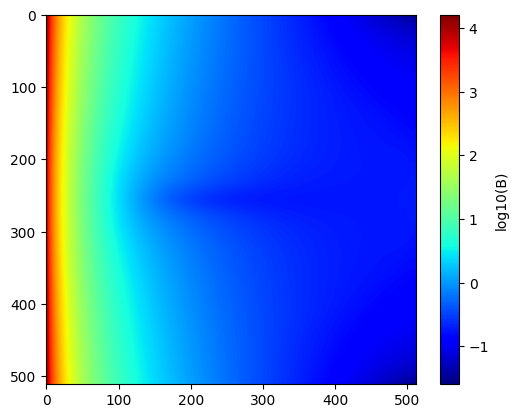

In [6]:
for x, y in dataloader:
    # Extract the data and labels from the batch
    x = x.to(device).float() # GPU
    y = np.array(y)
    print(x.shape, y.shape, y)
    break

fig, ax = plt.subplots()
s = plt.imshow(x[-1].cpu().detach().numpy().squeeze(),
                cmap="jet")
plt.colorbar(s, label='log10(B)');

## Model

In [7]:
from model import VAE

In [8]:
beta = 1.0
vae = VAE(image_channels=1, h_dim=256 * 1 * 1, z_dim=2, beta = beta, device=device)

## Training Pipeline

In [16]:
from train import train_model

In [17]:
output_dir='my_model'
lr=1e-3
epochs=1000

In [18]:
vae, hist = train_model(vae, dataloader, lr=lr, epochs=epochs)

  0%|          | 1/1000 [00:02<44:35,  2.68s/it]

Epoch: 1/1000, Loss: 326903.3125


 10%|█         | 101/1000 [01:35<13:17,  1.13it/s]

Epoch: 101/1000, Loss: 815.4166


 20%|██        | 201/1000 [03:07<12:13,  1.09it/s]

Epoch: 201/1000, Loss: 218.0161


 30%|███       | 301/1000 [04:40<10:49,  1.08it/s]

Epoch: 301/1000, Loss: 79.5678


 40%|████      | 401/1000 [06:12<09:13,  1.08it/s]

Epoch: 401/1000, Loss: 63.7870


 50%|█████     | 501/1000 [07:44<07:45,  1.07it/s]

Epoch: 501/1000, Loss: 47.9129


 60%|██████    | 601/1000 [09:17<06:19,  1.05it/s]

Epoch: 601/1000, Loss: 36.0043


 70%|███████   | 701/1000 [10:50<04:39,  1.07it/s]

Epoch: 701/1000, Loss: 31.8575


 80%|████████  | 801/1000 [12:22<03:01,  1.10it/s]

Epoch: 801/1000, Loss: 25.6205


 90%|█████████ | 901/1000 [13:54<01:32,  1.07it/s]

Epoch: 901/1000, Loss: 22.8725


100%|██████████| 1000/1000 [15:26<00:00,  1.08it/s]


In [20]:
# save and load the model    
from util import save_model, load_model, save_result, load_result
save_model(vae, model_path=f'./my_model/vae_beta={beta}.pth')
save_result(hist, filename=f'./my_model/vae_beta={beta}_hist.pkl')
#vae = load_model(vae, model_path='./my_model/vae_beta=1.0.pth')

## Plot latent vectors
Let’s plot the latent vector representations of a few batches of data.

In [21]:
batch_size = 1
shuffle = False
num_workers = 4
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

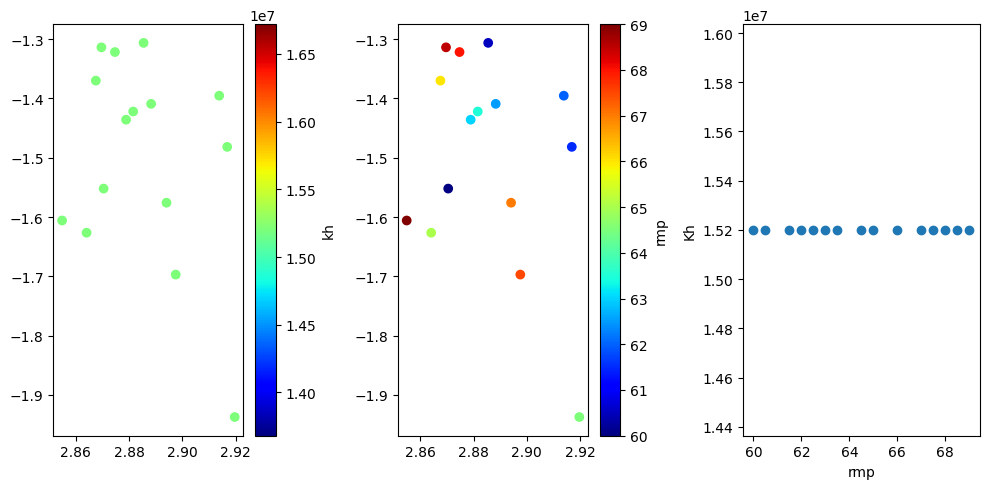

In [22]:
from plots import plot_latent
plot_latent(vae, dataloader)

Ideally, we would like to see an arrangement of colour, following the same arrangement as in the 3rd panel. This would indicate that the latent variables really correspond to the parameters 'kh' and 'rmp'. 

## Visualizing reconstructions

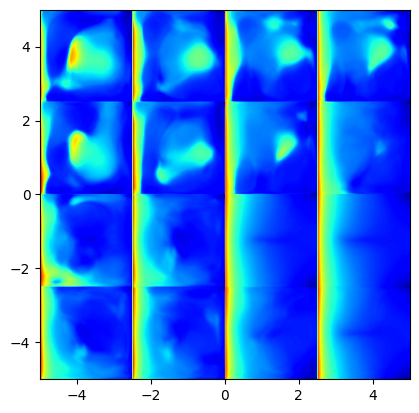

In [23]:
from plots import reconstruct, plot_reconstructed
plot_reconstructed(vae, width=512, z0=(-5, 5), z1=(-5, 5), n_img=4)

In [24]:
# load a sample from the dataloader
for x, y in dataloader:
    # Extract the data and labels from the batch
    x = x.to(device).float() # GPU
    y = np.array(y)
    break

# reconstruct sample
x_hat = reconstruct(vae.eval(), x, width)


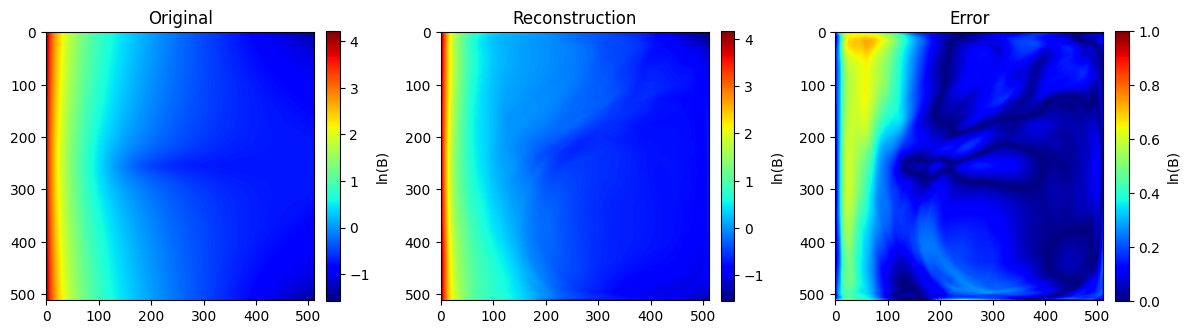

In [25]:
fig, ax = plt.subplots(1,3, figsize=(12,6))
x_orig = x[0].cpu().detach().numpy().squeeze()
err = np.sqrt((x_orig-x_hat)**2)
s1 = ax[0].imshow(x_orig, cmap="jet")
s2 = ax[1].imshow(x_hat, cmap="jet")
s3 = ax[2].imshow(err, cmap='jet', vmin=0, vmax=1)
ax[0].set_title('Original')
ax[1].set_title('Reconstruction')
ax[2].set_title('Error')
plt.colorbar(s1, label='ln(B)', ax=ax[0], fraction=0.046, pad=0.04);
plt.colorbar(s2, label='ln(B)', ax=ax[1], fraction=0.046, pad=0.04);
plt.colorbar(s3, label='ln(B)', ax=ax[2], fraction=0.046, pad=0.04);
plt.tight_layout()

## Visualizing interpolations

In [22]:
batch_size = 16
shuffle = True
num_workers = 4
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

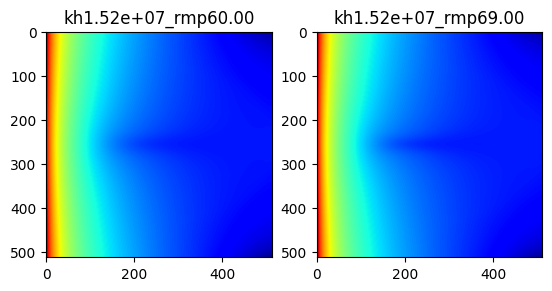

In [23]:
for x,y in dataloader:
    y = np.array(y)
    x_1 = x[y == 'kh1.52e+07_rmp60.00'][0].unsqueeze(dim=1).to(device).float() # find sample kh1.52e+07_rmp60.00
    x_2 = x[y == 'kh1.52e+07_rmp69.00'][0].unsqueeze(dim=1).to(device).float() # find sample kh1.52e+07_rmp69.00
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(x_1.cpu().detach().numpy().squeeze(), cmap='jet')
    ax[1].imshow(x_2.cpu().detach().numpy().squeeze(), cmap='jet')
    ax[0].set_title('kh1.52e+07_rmp60.00')
    ax[1].set_title('kh1.52e+07_rmp69.00')
    break

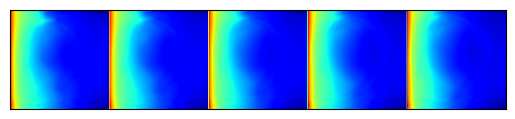

In [24]:
from plots import interpolate, interpolate_gif
interpolate(vae.eval(), x_1, x_2, width, n_img=5)

In [176]:
interpolate_gif(vae, width, "vae", x_1, x_2)